In [29]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np

np.random.seed(42)
# Charger les données MNIST avec seulement 100 étiquettes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
epochs = 60
train_dataset = datasets.MNIST(root='data/MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data/MNIST', train=False, download=True, transform=transform)

# Créer des listes pour chaque chiffre (0 à 9)
indices_per_digit = {i: [] for i in range(10)}

# Remplir les listes avec les indices correspondants à chaque chiffre
for idx, (image, label) in enumerate(train_dataset):
    indices_per_digit[label].append(idx)

# Sélectionner aléatoirement 10 indices pour chaque chiffre

selected_indices = []
for digit in range(10):
    digit_indices = np.random.choice(indices_per_digit[digit], size=10, replace=False)
    selected_indices.extend(digit_indices)

# Créer le sous-ensemble d'entraînement partiellement étiqueté
train_dataset_labeled = torch.utils.data.Subset(train_dataset, selected_indices)

train_loader = DataLoader(train_dataset_labeled, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Créer le modèle pour traiter les images MNIST en niveaux de gris et adapter la couche de classification
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes pour MNIST

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Créer une instance du modèle
classifier = Classifier()

# Définir l'optimiseur et la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Entraînement semi-supervisé
for epoch in range(epochs):
    classifier.train()
    for (labeled_images, labeled_labels), (unlabeled_images, _) in zip(train_loader, train_loader):
        optimizer.zero_grad()
        
        # Données étiquetées
        labeled_outputs = classifier(labeled_images)
        labeled_loss = criterion(labeled_outputs, labeled_labels)
        
        # Données non étiquetées pour générer des pseudo-étiquettes
        pseudo_labels = torch.argmax(classifier(unlabeled_images), dim=1)
        
        # Ajout des pseudo-étiquettes aux données non étiquetées
        pseudo_dataset = torch.utils.data.TensorDataset(unlabeled_images, pseudo_labels)
        pseudo_loader = DataLoader(pseudo_dataset, batch_size=64, shuffle=True)
        
        for pseudo_images, pseudo_labels in pseudo_loader:
            pseudo_outputs = classifier(pseudo_images)
            pseudo_loss = criterion(pseudo_outputs, pseudo_labels)
            pseudo_loss.backward(retain_graph=True)  # Retenir le graphe
            
        # Calcul de la perte totale
        total_loss = labeled_loss + pseudo_loss
        total_loss.backward()
        
        optimizer.step()

# Évaluation sur l'ensemble de test
classifier.eval()
total_correct = 0
total_images = 0

for images, labels in test_loader:
    outputs = classifier(images)
    _, predicted = torch.max(outputs, 1)
    total_images += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_images
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 85.87%


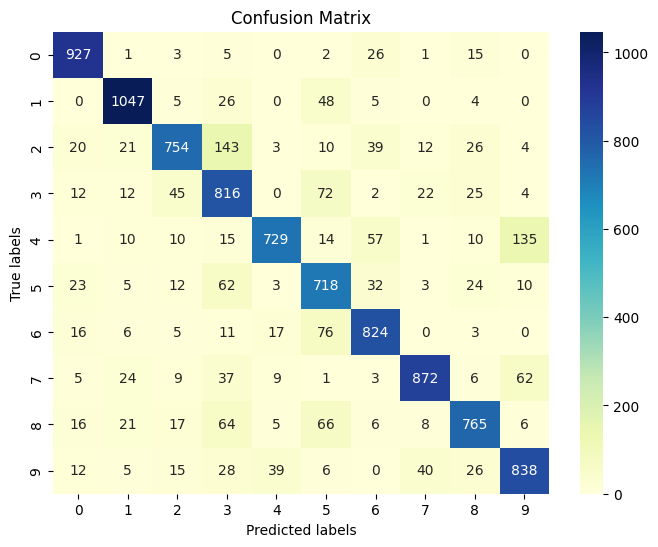

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Liste pour stocker les prédictions et les vraies étiquettes
all_preds = []
all_labels = []

# Prédictions sur l'ensemble de test
for images, labels in test_loader:
    outputs = classifier(images)
    _, predicted = torch.max(outputs, 1)
    all_preds.extend(predicted.tolist())
    all_labels.extend(labels.tolist())

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(all_labels,all_preds))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       980
           1       0.91      0.92      0.92      1135
           2       0.86      0.73      0.79      1032
           3       0.68      0.81      0.74      1010
           4       0.91      0.74      0.82       982
           5       0.71      0.80      0.75       892
           6       0.83      0.86      0.84       958
           7       0.91      0.85      0.88      1028
           8       0.85      0.79      0.81       974
           9       0.79      0.83      0.81      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [ ]:
from torchviz import make_dot

# Créer une instance du modèle
classifier = Classifier()  # Assurez-vous d'avoir défini la classe Classifier précédemment

# Créer un tenseur aléatoire pour simuler une entrée
dummy_input = torch.randn(1, 1, 28, 28)  # Batch de 1, canal unique, taille 28x28

# Obtenir la sortie du modèle pour la représentation graphique
outputs = classifier(dummy_input)

# Générer le graphe
dot = make_dot(outputs, params=dict(classifier.named_parameters()))

# Enregistrer le graphe au format PDF (ou autre format souhaité)
dot.render("CNN_architecture", format="pdf")
